In [157]:
import sys

import pandas 
import scipy

import matplotlib.pyplot
import seaborn

import random

sys.path.append("../scripts")
import utils

In [158]:
def parse_scores(scores_file):
    # load scores
    scores = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores[ENSG] = float(score)

    return scores

In [159]:
def parse_leave_one_out(scores_file):
    # load left-out scores
    scores_left_out = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores_left_out[ENSG] = float(score)
        
    return scores_left_out

In [160]:
def check_pvalue(pvalue):
    if pvalue < 0.0001:
        return "p-value < 0.0001"
    if pvalue < 0.001:
        return "p-value < 0.001"
    if pvalue < 0.01:
        return "p-value < 0.01"
    if pvalue < 0.05:
        return "p-value < 0.05"
    else:
        return "p-value >= 0.05"

In [161]:
def compare_scores(scores, scores_left_out):
    scores = scores.copy()
    for left_out in scores_left_out:
        del scores[left_out]

    df_scores = pandas.DataFrame.from_dict(scores, 
                                       orient='index', 
                                       columns=['score'])
    df_scores['group'] = "non-causal"

    df_scores_left_out = pandas.DataFrame.from_dict(scores_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_scores_left_out['group'] = 'left-out'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_scores, df_scores_left_out])

    stat, pvalue = scipy.stats.ranksums(df_scores['score'].values, df_scores_left_out['score'].values, alternative='less')

    pvalue_thresh = check_pvalue(pvalue)

    print(stat, pvalue)

    return df_compare, pvalue_thresh

In [162]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

In [163]:
def geneName_to_ENSG(genes_file):
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

#### Set parameters

In [466]:
PHENOTYPE = "MMAF"
ALPHA = 0.5
D_MAX = 10
ALPHA_NORM = 10

NEW_CENTRALITY_VERSION = "v8"


#### Load the necessary data

In [467]:
interactome = utils.parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

alpha = str(ALPHA).replace('.', '')
scores = parse_scores(f"/home/kubicaj/calc/output/New_centrality_{NEW_CENTRALITY_VERSION}/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores.tsv")
scores_leave_one_out = parse_leave_one_out(f"/home/kubicaj/calc/output/New_centrality_{NEW_CENTRALITY_VERSION}/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores_leave_one_out.tsv")

#### Analyze leave-one-out results: newCentrality.py

In [468]:
df_compare, p_value = compare_scores(scores, scores_leave_one_out)

-2.9393219338793757 0.0016446560872250499


Text(0.5, 1.0, 'Compare non-causal genes scores (all MMAF genes used)\n with scores for MMAF genes (leave-one-out)\nalpha=0.5,   d=10,    alpha_norm=10')

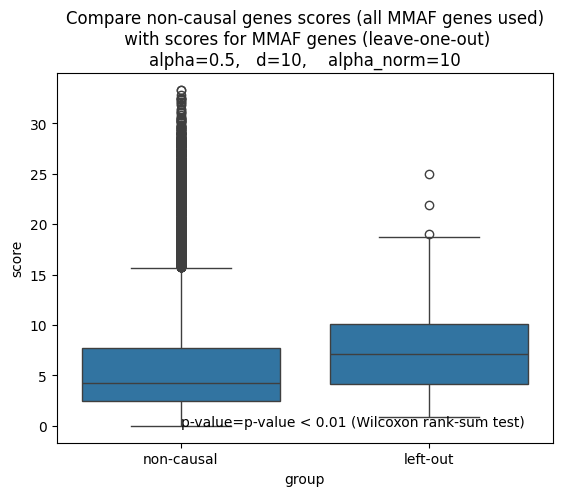

In [469]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")
# matplotlib.pyplot.ylim(0,2)

In [470]:
# top 10 high-scoring genes
scores_sorted = {node: score for node, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
scores_sorted

{'ENSG00000057704': 33.31079038307086,
 'ENSG00000244617': 33.26057090387896,
 'ENSG00000104889': 32.7771598116371,
 'ENSG00000184465': 32.52811305789777,
 'ENSG00000223638': 32.482577443164786,
 'ENSG00000166997': 32.41151644676858,
 'ENSG00000177947': 32.40751461785441,
 'ENSG00000219481': 32.263673585068155,
 'ENSG00000138722': 32.122663040337954,
 'ENSG00000151304': 32.09846070991335,
 'ENSG00000196678': 31.877862417113665,
 'ENSG00000170381': 31.78230493596989,
 'ENSG00000145681': 31.411868655493553,
 'ENSG00000099834': 31.281163812751174,
 'ENSG00000160223': 31.11392326987298,
 'ENSG00000047662': 31.096548882385164,
 'ENSG00000102539': 30.97776598021567,
 'ENSG00000172780': 30.836400816240843,
 'ENSG00000176371': 30.67567105627309,
 'ENSG00000075073': 30.57401036705426,
 'ENSG00000163380': 30.573475333673972,
 'ENSG00000168874': 30.42850896325421,
 'ENSG00000164941': 30.400488824746354,
 'ENSG00000215045': 30.316099056276546,
 'ENSG00000091490': 30.30996931561789,
 'ENSG000001597

In [471]:
len(scores), len(scores_sorted)

(14393, 14393)

#### Analyze new candidates from 13/02/2024

In [472]:
genes = geneName_to_ENSG("/home/kubicaj/calc/input/canonicalGenes.tsv")

In [473]:
new_candidates_names = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
new_candidates_ENSG = [genes.get(n) for n in new_candidates_names]
new_candidates = [n for n in new_candidates_ENSG if n in interactome]

In [474]:
# check scores of new candidates
scores_new_candidates = {n: scores.get(n) for n in new_candidates}

In [475]:
scores_new_candidates

{'ENSG00000162994': 15.175948441333654,
 'ENSG00000025293': 11.650572447567654,
 'ENSG00000164287': 2.3139972074598143,
 'ENSG00000188732': 4.802753081417613,
 'ENSG00000128310': 25.400609654587154,
 'ENSG00000165115': 7.4467553960702295,
 'ENSG00000180376': 10.103471588053022,
 'ENSG00000133101': 2.261569863393083,
 'ENSG00000080007': 0.0,
 'ENSG00000142621': 13.227145115439935,
 'ENSG00000136449': 8.118827941145526,
 'ENSG00000078814': 5.232602464364986,
 'ENSG00000165698': 6.6144223696815265,
 'ENSG00000170469': 5.024452834776997,
 'ENSG00000132122': 5.135540059681916,
 'ENSG00000139908': 10.206982897954576,
 'ENSG00000120440': 25.91922196109475}

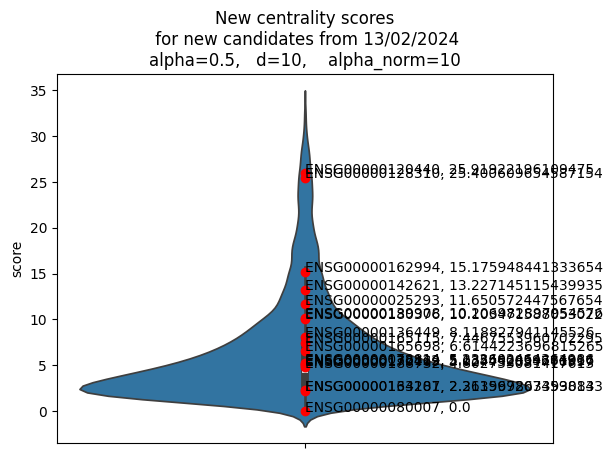

In [476]:
seaborn.violinplot(data=df_compare, y='score')
matplotlib.pyplot.title(f"New centrality scores\n for new candidates from 13/02/2024\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")

for canidate, score in scores_new_candidates.items():
    matplotlib.pyplot.plot(score, 'or')
    matplotlib.pyplot.text(0, score, s=f"{canidate}, {score}")

### Compare New centrality with other centralities (degree, betweenness)

In [477]:
CENTRALITY = "degree"

In [478]:
scores_leave_one_out_sorted = {node: score for node, score in sorted(scores_leave_one_out.items(), key=lambda item: item[0], reverse=True)}

In [479]:
scores_centrality = parse_scores(f"/home/kubicaj/calc/output/{CENTRALITY}_centrality/{PHENOTYPE}/scores.tsv")
scores_centrality = {node: score for node, score in scores_centrality.items() if node in scores}
scores_centrality_sorted = {node: score for node, score in sorted(scores_centrality.items(), key=lambda item: item[0], reverse=True)}

scores_centrality_causal = {node: score for node, score in scores_centrality.items() if node in scores_leave_one_out}
scores_centrality_causal_sorted = {node: score for node, score in sorted(scores_centrality_causal.items(), key=lambda item: item[0], reverse=True)} 

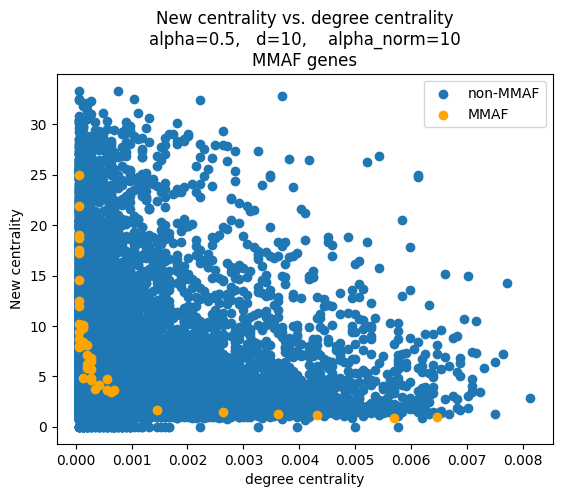

In [480]:
matplotlib.pyplot.scatter(x=scores_centrality_sorted.values(), y=scores_sorted.values(), label=f"non-{PHENOTYPE}")
matplotlib.pyplot.scatter(x=scores_centrality_causal_sorted.values(), y=scores_leave_one_out_sorted.values(), c='orange', label=f"{PHENOTYPE}")

matplotlib.pyplot.title(f"New centrality vs. {CENTRALITY} centrality\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\n{PHENOTYPE} genes")
matplotlib.pyplot.ylabel("New centrality")
matplotlib.pyplot.xlabel(f"{CENTRALITY} centrality")
matplotlib.pyplot.legend()

#### Random sampling New centrality vs. other centralities

In [481]:
random.seed(1)

random_sample_size = len(scores_leave_one_out)
random_sample = random.sample(list(scores_centrality), random_sample_size)

scores_centrality_random_sample = {}
scores_random_sample = {}

for node in random_sample:
    scores_centrality_random_sample[node] = scores_centrality[node]
    scores_random_sample[node] = scores[node]

In [482]:
scores_centrality_random_sample_sorted = {node: score for node, score in sorted(scores_centrality_random_sample.items(), key=lambda item: item[0], reverse=True)}
scores_random_sample_sorted = {node: score for node, score in sorted(scores_random_sample.items(), key=lambda item: item[0], reverse=True)}

In [483]:
# DC_random + NC_random
x = list(scores_centrality_random_sample_sorted.values()) + list(scores_random_sample_sorted.values())
# DC_MMAF + NC_MMAF
y = list(scores_centrality_causal_sorted.values()) + list(scores_leave_one_out_sorted.values())

stats, p_value = scipy.stats.pearsonr(x, y)
R2 = '{:g}'.format(float('{:.1g}'.format(stats**2)))
p_value = '{:g}'.format(float('{:.1g}'.format(p_value)))

Text(6.948304613674263e-05, 6.948304613674263e-05, 'R^2 = 0.3\np-value = 4e-07 (Pearson)')

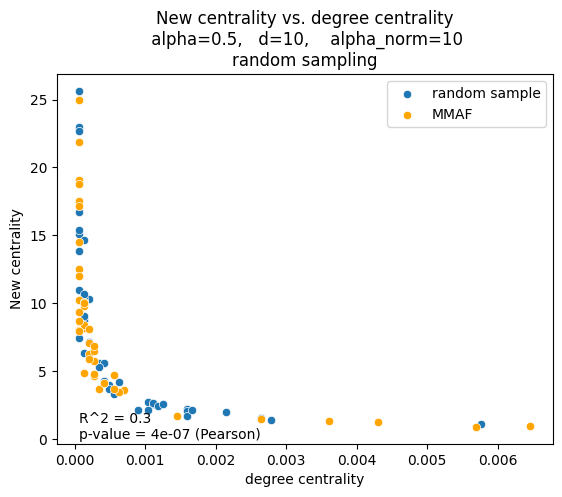

In [484]:
seaborn.scatterplot(x=list(scores_centrality_random_sample_sorted.values()),
                y=list(scores_random_sample_sorted.values()),
                label='random sample')

seaborn.scatterplot(x=list(scores_centrality_causal_sorted.values()),
                y=list(scores_leave_one_out_sorted.values()),
                color='orange',
                label='MMAF')

matplotlib.pyplot.title(f"New centrality vs. {CENTRALITY} centrality\n alpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\nrandom sampling")
matplotlib.pyplot.ylabel("New centrality")
matplotlib.pyplot.xlabel(f"{CENTRALITY} centrality")
matplotlib.pyplot.text(x=min(x), y=min(y), s=f"R^2 = {R2}\np-value = {p_value} (Pearson)")